Autor: Joshua Daniel Hernandez Coronado

In [2]:
!pip install opendatasets #instalamos opendatasets para poder utilizar los datasets de Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se importan las librerias correspondientes para poder hacer uso de las diferentes funciones y metodos contenidos en estas, dentro de las librerias mencionadas podemos encontrar librerias para el uso de los datos como para el desarollo de nuestra red neuronal.

In [4]:
import opendatasets as od
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import tensorflow
import pickle
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras import models
from keras.backend import categorical_crossentropy
     
%matplotlib inline

In [5]:
import plotly.express as px

##Cargar Imagenes

In [6]:
od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification",force = True) # Se cargan los datos referentes a los datasets de train y test

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: joshuahc
Your Kaggle Key: ··········


100%|██████████| 346M/346M [00:01<00:00, 238MB/s]


In [7]:
dir_train = "intel-image-classification/seg_train/seg_train" #Se apunta a la direccion del set para train

In [8]:
dir_test = "intel-image-classification/seg_test/seg_test" # Se apunta a la dirreccion del set para test

In [9]:
#esta funcion  nos permite crear un dirgrama de pie donde observamos la distribucion de las clases dentro del dataset
def ploti(dir_train,which):  #debemos darle la direccion del datatset y un nombre para las ejecuciones
    directory=os.listdir(dir_train)
    train=pd.DataFrame(directory,columns=['folders'])
    counts=[]
    for i in directory:
        path=dir_train+'/'+i
        num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
        counts.append(num_files)
    train['counts']=counts
    fig = px.pie(train, values='counts', names='folders', title='distribution across '+str(which))
    fig.show()

In [10]:
ploti(dir_train,'Train')
ploti(dir_test,"Validation") #llamamos la funcion

In [11]:
#preparamos las imagenes de nuestro set para que puedan tener el formato correcto esto se hace  mediante la siguiente funcion:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45, #rango permitido de rotacion
    horizontal_flip=True, #Se indica el giro horizontal
    vertical_flip=True, #Se indica el giro vertical
    fill_mode='reflect',
    validation_split=0.3 # Se determina el tamaño de la muestra para la validacion
) # Esta funcion permite regular la orientacion 

     

In [12]:
# Se hace una segund prepracion esta vez para el set de train
train = datagen.flow_from_directory( #con esta funcion se realiza el ajuste de tamaño asi como la seleccion del tipo de muestra con la que se trabaja
    dir_train,
    batch_size=64,
    target_size=(128,128),
    class_mode="categorical",
    subset="training"
) # esta funcion nos indicara las el numero de muestras que tenemos en total asi como el total de clases en el set de train

Found 9826 images belonging to 6 classes.


In [13]:
# Se hace una segund prepracion esta vez para el set de test

test = datagen.flow_from_directory(#con esta funcion se realiza el ajuste de tamaño asi como la seleccion del tipo de muestra con la que se trabaja
    dir_test,
    batch_size=64,
    target_size=(128,128),
    class_mode="categorical",
    subset="validation",
) # esta funcion nos indicara las el numero de muestras que tenemos en total asi como el total de clases en el set de test

Found 898 images belonging to 6 classes.


In [14]:
train.class_indices # se imprimen los indices de las clases para asegurar que los datos esten intactos en lo que respecta a la segmentacion

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [15]:
test.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

##Lista de los NS y clases

In [16]:
TrainClasses = train.class_indices
ResultMap = {}

In [17]:
for NSValue,NSName in zip(TrainClasses.values(),TrainClasses.keys()):
  ResultMap[NSValue]=NSName # se hace el calculo de neuronas de salidas tomando en cuenta las clases

In [18]:
OutputNeurons = len(ResultMap)
print("Numero de neuronas de salida: ",OutputNeurons)

Numero de neuronas de salida:  6


##Modelo CNN

Para generar la arquitectura de la red neuronal es necesario comprender algunos elementos necesarios dentro del desarollo de la misma para ello se tiene lo siguiente la explicacion de los componentes de que componen las capas:

* Sequential: Este metodo permite agrupar una pila lineal de capas en un archivo legible para keras.
* Convolution:extrae características propias de cada imagen comprimiéndolas para reducir su tamaño inicial.
* MaxPool:Realiza un proceso de discretización basado en muestras. Su objetivo es submuestrear una representación de entrada.
* Flatten:Transforma nuestra matriz multidimensional generada por cpnvolution y maxpool en una matriz unidimensional.
* Dense:Realiza una reduccion de la capa.
* add:permite que se ensamble la red.

In [19]:
#Iniciamos la Red ......

# para esta parte fue necesario la libreria de keras y sus derivados
classifier = Sequential()

#Convolution ......
classifier.add(Convolution2D(32,kernel_size=(3,3), strides =(1,1),input_shape =(128,128,3),activation="relu")) 

#Max Pooling ......
classifier.add(MaxPool2D(pool_size =(2,2)))

In [20]:
#Optimizaion del Accuracy con una doble capa
classifier.add(Convolution2D(64, kernel_size =(3,3), strides = (1,1), activation = "relu"))

classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Convolution2D(128, kernel_size =(3,3), strides = (1,1), activation = "relu" ))

classifier.add(MaxPool2D(pool_size =(2,2)))

In [21]:
#Adiccion de Flatten .......
classifier.add(Flatten())

In [22]:
#Adiccion de Dense
classifier.add(Dense(256, activation="relu"))

In [23]:
#Salida de la red
classifier.add(Dense(OutputNeurons,activation="softmax"))


In [24]:
#Compilacion de la red

classifier.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics = ["accuracy"])

In [25]:
classifier.summary() # Observamos la arquitectura generada en los pasos anteriores

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [29]:
model = classifier.fit(train, steps_per_epoch=len(train),epochs=15,validation_data=test,validation_steps=len(test),verbose=1) #Entrenamos el modelo que generamos

Epoch 1/15
154/154 [==============================] - 362s 2s/step - loss: 1.1306 - accuracy: 0.5576 - val_loss: 1.0827 - val_accuracy: 0.5824
Epoch 2/15
154/154 [==============================] - 342s 2s/step - loss: 1.0165 - accuracy: 0.6118 - val_loss: 0.9984 - val_accuracy: 0.6336
Epoch 3/15
154/154 [==============================] - 340s 2s/step - loss: 0.9265 - accuracy: 0.6527 - val_loss: 0.9395 - val_accuracy: 0.6670
Epoch 4/15
154/154 [==============================] - 348s 2s/step - loss: 0.8729 - accuracy: 0.6805 - val_loss: 0.8310 - val_accuracy: 0.7049
Epoch 5/15
154/154 [==============================] - 345s 2s/step - loss: 0.8281 - accuracy: 0.6928 - val_loss: 0.7917 - val_accuracy: 0.7238
Epoch 6/15
154/154 [==============================] - 348s 2s/step - loss: 0.7869 - accuracy: 0.7125 - val_loss: 0.8674 - val_accuracy: 0.6759
Epoch 7/15
154/154 [==============================] - 345s 2s/step - loss: 0.7533 - accuracy: 0.7267 - val_loss: 0.7638 - val_accuracy: 0.7305

In [30]:
accuracy = model.history["accuracy"]
val_accuracy  = model.history["val_accuracy"] #obtenemos los valores del accuracy

loss = model.history["loss"] # Obtenmos los valores de perdida del modelo
val_loss = model.history["val_loss"]

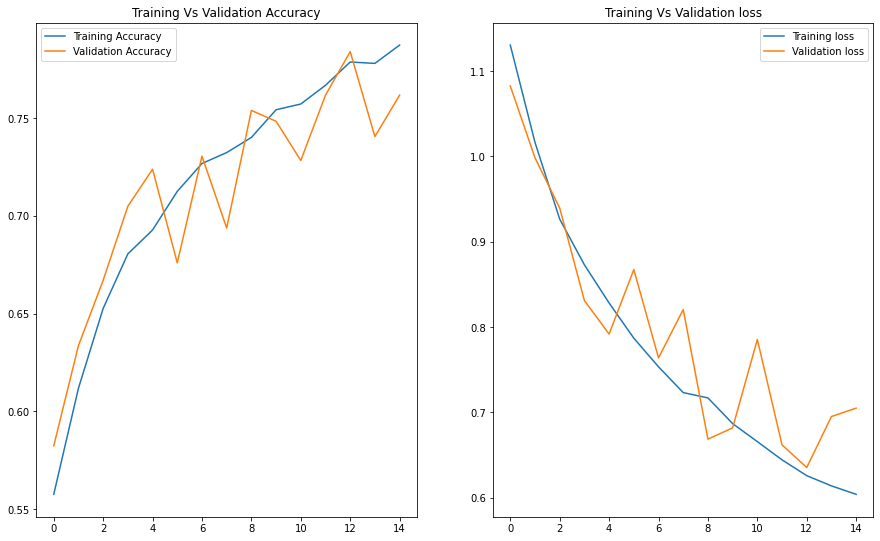

In [31]:
#graficamos los valores de perdida y Accuracy para ver como fue el desempeño del modelo con la muestra de train y test
plt.figure(figsize=(15,20)) 
plt.subplot(2,2,1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend()
plt.title("Training Vs Validation Accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()
plt.title("Training Vs Validation loss")

plt.show()

## Validacion con muestra externa

In [32]:
#Creamos una funcion con la cual le daremos al modelo la imagenes que vamos a probar
def testing_clf(clf, img):
  pimg = cv2.imread(img)
  pimg = cv2.cvtColor(pimg, cv2.COLOR_BGR2GRAY)
  pimg = cv2.resize(pimg,(48,48))

  pimg = np.expand_dims(pimg,axis = 0)
  pimg = pimg.reshape(1,48,48,1)
  result = clf.predict(pimg)
  result = list(result[0])
  labels = {'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}
  label = np.argmax(result)
  return labels[label]

In [ ]:
testing_clf(model,"/content/Buildings.jpg")